In [1]:
import pandas as pd
from datetime import datetime   # 패키지 - 모듈 (이름 같음)
import pandas as pd   # csv file read
import matplotlib.pyplot as plt   # 시계열 시각화
from sklearn.preprocessing import LabelEncoder # 인코딩
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
plt.style.use('ggplot')
pd.options.display.float_format = '{:.5f}'.format

C:\Users\yjhon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\yjhon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Dataset import

In [6]:
df = pd.read_csv('C:/Users/yjhon/OneDrive/바탕 화면/조달청_공모전/Regression_timeseries/물품용역공사_2017_2021.xls',index_col='공고게시일자')

In [7]:
table = df.수요기관명.value_counts()

In [8]:
pd.DataFrame(table).head()

,수요기관명
방위사업청,62468
한국수자원공사,13366
서울특별시,11746
한국도로공사,9715
서울교통공사,8109


In [9]:
df.index = df.index.astype(str)

df.index = pd.to_datetime(df.index)

In [10]:
water_df = df[df.수요기관명 == "한국수자원공사"] # 용역
water_df_service = water_df[water_df.대상 == "용역"]

In [11]:
col_name = ["추정가격"]
water_service = pd.DataFrame(data = water_df_service,columns = col_name)

In [12]:
water_service['date'] = water_service.index
water_service.dtypes

water_service['date'] = water_service['date'].astype(str)

water_service['date'] = pd.to_datetime(water_service['date'])

water_groups = water_service.groupby(["date"]).추정가격.sum()
water_group_df = pd.DataFrame(data=water_groups, index = water_groups.index)


In [13]:
weekly_df = water_group_df.resample('1W').추정가격.sum() #fillna(0)
weekly_df_df=pd.DataFrame(weekly_df)

In [14]:
weekly_df_fin = weekly_df_df[weekly_df_df.추정가격 !=0]
weekly_df_fin.shape
weekly_df_fin

,추정가격
date,
2018-04-08,1213394500.00000
2018-04-15,2100809455.00000
2018-04-22,5161653780.00000
2018-04-29,1889171056.00000
2018-05-06,8386696600.00000
...,...
2021-12-05,15323871280.00000
2021-12-12,15572623196.00000
2021-12-19,23078195505.00000


Text(0.5, 1.0, '한국수자원공사 용역 추정가격_week')

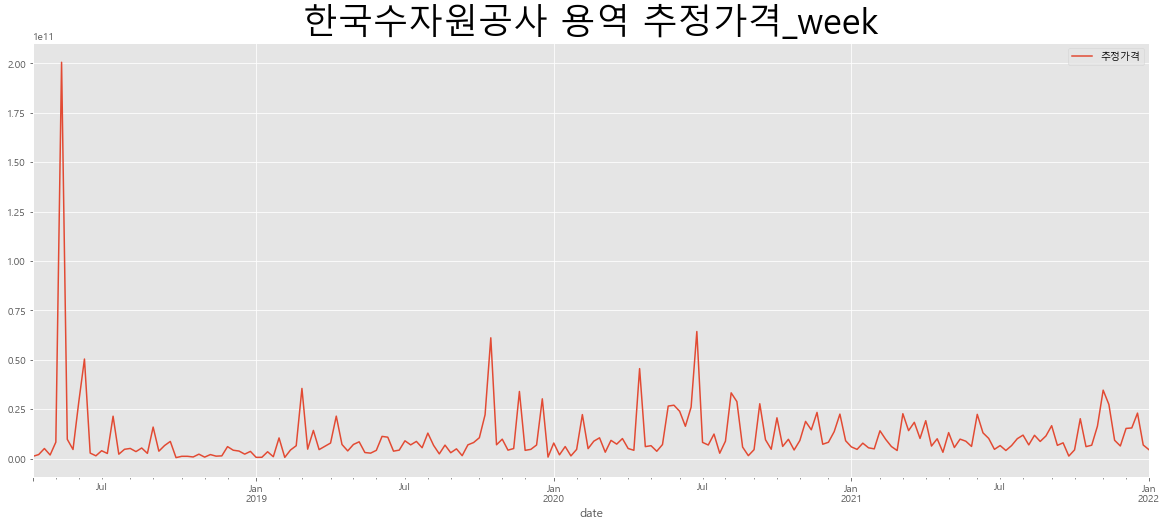

In [15]:
weekly_df_fin.plot(figsize=(20,8))
plt.title("한국수자원공사 용역 추정가격_week",fontsize=35)

# 단위근 검정

In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(weekly_df_fin[1:])
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print('Critical values:')
for key, value in result[4].items():
    print('\t%s:%.3f'%(key,value))

ADF Statistic: -13.060865
p-value : 0.000000
Critical values:
	1%:-3.465
	5%:-2.877
	10%:-2.575


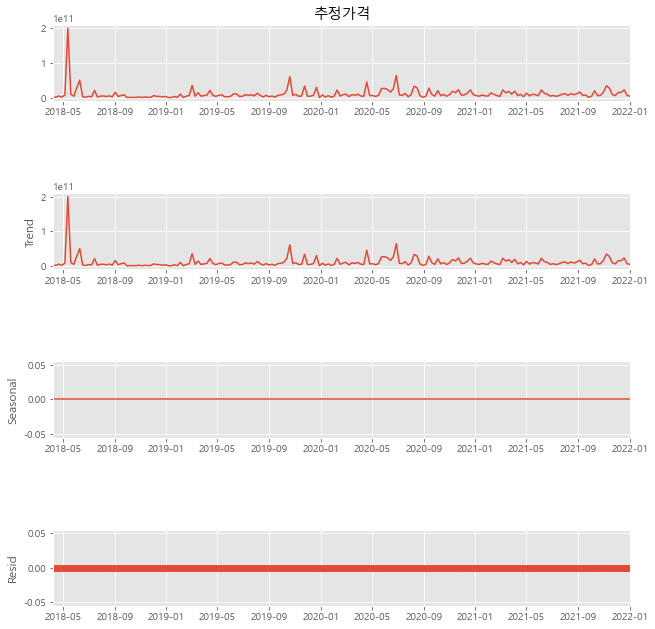

In [17]:
decomposition = sm.tsa.seasonal_decompose(weekly_df_fin['추정가격'],model='additive',period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()


# observed: 실제관측치에 대한 row data
# Trend
# Seasonal
# resi

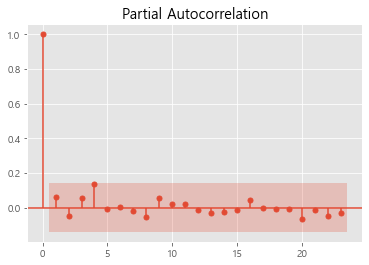

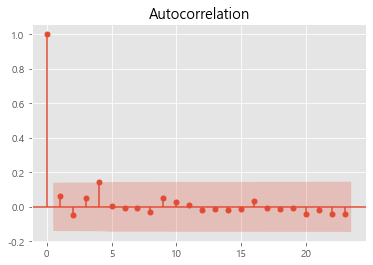

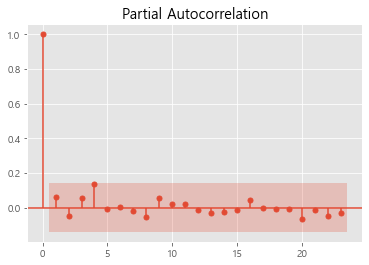

In [18]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(weekly_df_fin.추정가격)
plot_pacf(weekly_df_fin.추정가격)

<AxesSubplot:xlabel='date'>

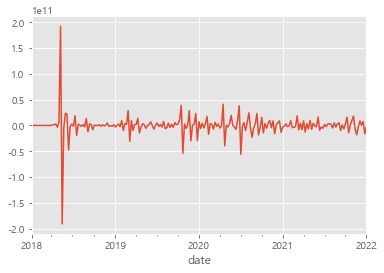

In [24]:
temple_sample = weekly_df
temple_sample.diff().plot()

# train / test set 분리

In [1]:
y_train = weekly_df_fin['추정가격'][:int(0.7*len(weekly_df_fin))]
y_test = weekly_df_fin['추정가격'][int(0.7*len(weekly_df_fin)):]
y_train.plot()
y_test.plot()

NameError: name 'weekly_df_fin' is not defined

# MinMax scaling

In [27]:
# 정규화 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

y_train_sc_temp = y_train.values.reshape(-1,1)

y_train_sc = sc.fit_transform(y_train_sc_temp)

y_test_sc_temp = y_test.values.reshape(-1,1)
y_test_sc = sc.fit_transform(y_test_sc_temp)

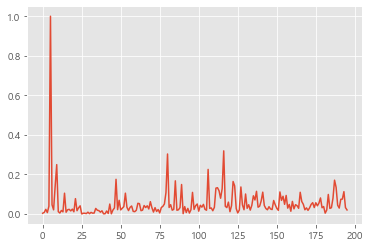

In [28]:
water_sample_minmax = sc.fit_transform(weekly_df_fin)
plt.plot(water_sample_minmax)

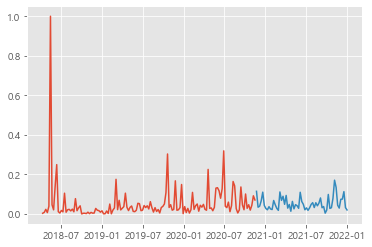

In [29]:
y_train_mm = water_sample_minmax[:int(0.7*len(water_sample_minmax))]
y_test_mm = water_sample_minmax[int(0.7*len(water_sample_minmax)):]
plt.plot(y_train.index,y_train_mm)
plt.plot(y_test.index, y_test_mm)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

kpss_diffs = ndiffs(y_train_mm, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train_mm, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 0


In [31]:
model = pm.auto_arima(y = y_train_mm        # 데이터
                      , d = 1            # 차분 차수, ndiffs 결과!
                      , D = 1
                      , start_p = 0 
                      , max_p = 5   
                      , start_q = 0 
                      , max_q = 5   
                      , m = 52       
                      , seasonal = True # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      #, trend = True
                      )
model.fit(y_train_mm)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=-46.453, Time=2.52 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=-50.199, Time=0.38 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=-65.085, Time=3.12 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=-91.570, Time=5.87 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=-93.313, Time=0.63 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=-91.570, Time=6.00 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=-89.570, Time=5.30 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=-91.679, Time=1.22 sec
 ARIMA(0,1,2)(0,1,0)[52]             : AIC=-91.706, Time=1.21 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=-67.053, Time=0.39 sec
 ARIMA(1,1,2)(0,1,0)[52]             : AIC=-89.784, Time=1.73 sec
 ARIMA(0,1,1)(0,1,0)[52] intercept   : AIC=-92.082, Time=2.66 sec

Best model:  ARIMA(0,1,1)(0,1,0)[52]          
Total fit time: 31.040 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 52),
      suppress_warnings=True, with_intercept=False)

C:\Users\yjhon\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


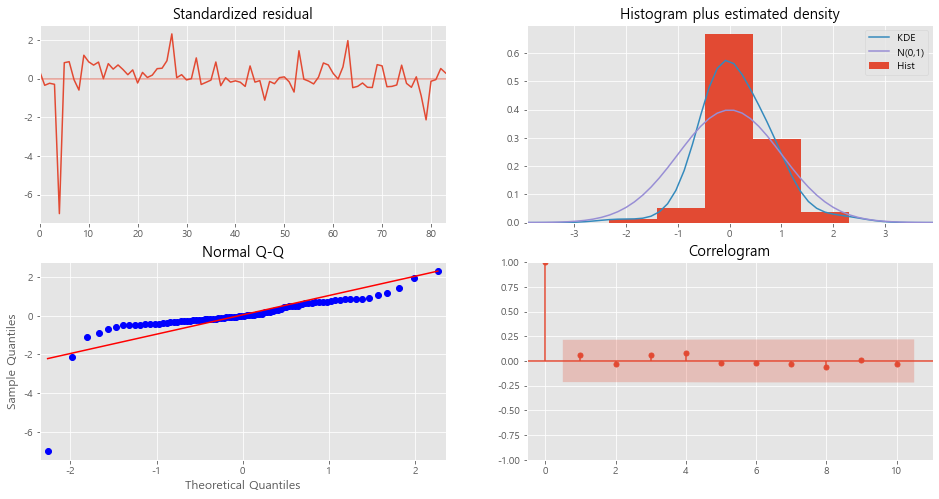

In [32]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

# 결과 확인

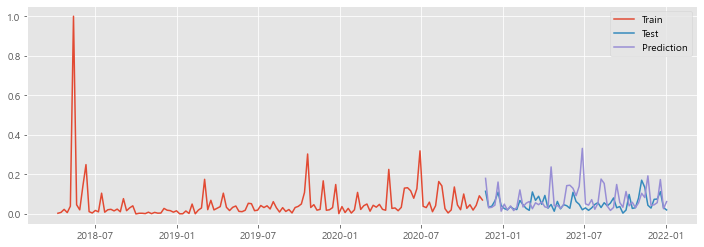

In [33]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test_mm)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train.index,y_train_mm, label='Train')        # 훈련 데이터
plt.plot(y_test.index,y_test_mm, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

# pred 전체 plot

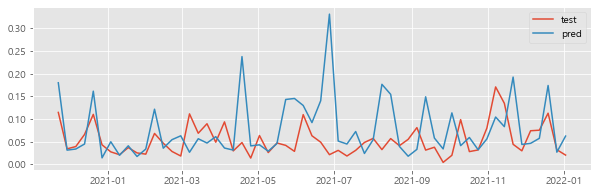

In [34]:
y_index = y_test.index
y_test_temp_val = y_test_mm
y_pred_temp_val = y_predict
plt.figure(figsize=(10,3))
plt.plot(y_test.index,y_test_temp_val,label="test")
plt.plot(y_pred_temp_val,label="pred")
plt.legend()
plt.show()

# pred 범위축소 plot

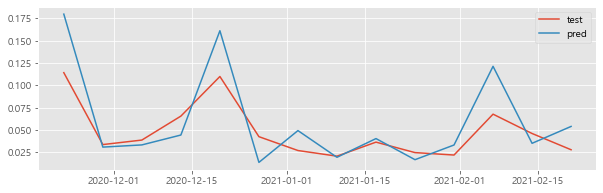

In [35]:
y_index = y_test.index[:14]
y_test_temp_val = y_test_mm[:14]
y_pred_temp_val = y_predict[:14]
plt.figure(figsize=(10,3))
plt.plot(y_index,y_test_temp_val,label="test")
plt.plot(y_pred_temp_val,label="pred")
plt.legend()
plt.show()

# 1차 검증 _전체

In [36]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(y_test_mm, y_predict) 
np.sqrt(MSE)

0.07093013849486794

# 1차 검증_범위 축소

In [37]:
#y_index = y_test.index[:14]
y_test_temp_val = y_test_mm[:14]
y_pred_temp_val = y_pred_temp_val[:14]

MSE = mean_squared_error(y_test_temp_val, y_pred_temp_val) 
np.sqrt(MSE)

0.030009845044162885